In [1]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load Data and keep year from release date
data = pd.read_csv("./data/movie_data_imdbscores.csv")
data.release_date = pd.to_datetime(data.release_date).apply(lambda x: x.year)


# Select features to keep in analysis


# WE DO NOT KEEP RUN TIME AND ACTOR AGE AT MOVIE RELEASE BECAUSE OF NA


to_keep = ['movie_id', 'release_date', 
           #'runtime', 'actor_age_at_movie_release',
       'english language','german language', 'silent film language', 'spanish language',
       'japanese language', 'italian language', 'tamil language',
       'hindi language', 'malayalam language', 'mandarin language',
       'french language', 'Action', 'Adventure', 'Horror', 'Thriller', 'Drama',
       'Crime Fiction', 'Black-and-white', 'Comedy', 'Indie', 'Short Film',
       'Silent film', 'Family Film', 'World cinema', 'Musical',
       'Action/Adventure', 'Romance Film', 'Romantic drama', 'Comedy film',
       'Documentary', 'F_gender_porportion', 'averageRating',
       'numVotes']
data = data[to_keep].set_index('movie_id')

In [3]:
data.head()

,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,malayalam language,...,World cinema,Musical,Action/Adventure,Romance Film,Romantic drama,Comedy film,Documentary,F_gender_porportion,averageRating,numVotes
movie_id,,,,,,,,,,,,,,,,,,,,,
30332673,2010,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0.666667,3.7,3222
4213160,1971,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,0.250000,6.3,2631
20624798,2008,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,0.111111,7.2,22
2250713,1988,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.000000,5.9,82
25969588,2007,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.200000,6.4,346


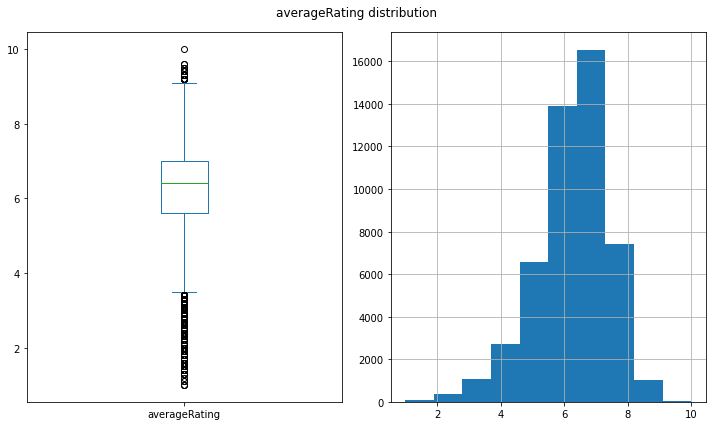

In [4]:
# Plot averageRating distribution

fig, ax = plt.subplots(1, 2, figsize = (10,6))
ax = ax.flatten()
data.averageRating.plot.box(ax = ax[0])
data.averageRating.hist(ax = ax[1])
fig.suptitle("averageRating distribution")
plt.tight_layout()
plt.show()

In [5]:
data.averageRating.describe()

count    49785.000000
mean         6.224752
std          1.146467
min          1.000000
25%          5.600000
50%          6.400000
75%          7.000000
max         10.000000
Name: averageRating, dtype: float64

In [6]:
# Discretize feature based on quantiles
def discretize_column(data, n, label_suffix = "_star"):
    
    # Compute proportion for quantile
    p = 1/(n)
    
    # Return semgments
    return pd.cut(data,
                  # Create interval cuts
                  bins = [np.quantile(data, x * p) if x != n else np.inf
                          for x in range(n+1)],
                  right = False,
                  # assign labels
                  labels = [f"{i+1}{label_suffix}" for i in range(n)])

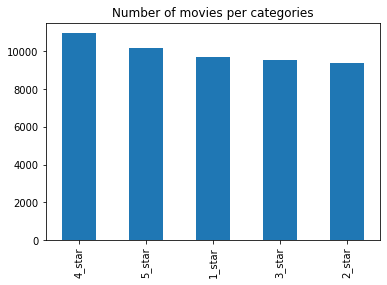

In [7]:
# Perform discretization and save categories in new feature
data["score_discretized"] = discretize_column(data.averageRating, 5)

# Verify Discretization proportions
data.score_discretized.value_counts().plot.bar()
plt.title("Number of movies per categories")
plt.show()

In [8]:
# Compute mean proportions and means for numeric values
grouped = data.groupby('score_discretized')
grouped_means = grouped.mean()
grouped_means

,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,malayalam language,...,World cinema,Musical,Action/Adventure,Romance Film,Romantic drama,Comedy film,Documentary,F_gender_porportion,averageRating,numVotes
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1986.497834,0.631628,0.014442,0.025273,0.023623,0.013720,0.027646,0.024345,0.076026,0.017124,...,0.089849,0.049618,0.112956,0.124097,0.040128,0.038684,0.006293,0.342291,4.456994,2526.612544
2_star,1977.950340,0.653764,0.019779,0.031370,0.028286,0.018928,0.029775,0.015951,0.045725,0.010102,...,0.089217,0.056678,0.091876,0.167695,0.055402,0.044981,0.009251,0.339252,5.724777,4220.002765
3_star,1976.805981,0.635467,0.021091,0.026758,0.034523,0.026967,0.035047,0.014376,0.041763,0.009759,...,0.100630,0.059916,0.085729,0.169780,0.063694,0.038300,0.015110,0.341454,6.304344,6221.281637
4_star,1977.724399,0.572613,0.035714,0.028972,0.045554,0.032799,0.038356,0.017128,0.048925,0.013484,...,0.140671,0.060313,0.072977,0.165270,0.067875,0.033072,0.024690,0.335895,6.842365,9172.384111
5_star,1981.735979,0.510362,0.040369,0.019350,0.042039,0.042137,0.032413,0.032119,0.062764,0.021020,...,0.170808,0.064434,0.055201,0.149298,0.065809,0.031628,0.064728,0.313692,7.629427,30623.601316


In [9]:
# Visualize the best and worst scoring groups

grouped_means.iloc[[0,-1], :]

,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,malayalam language,...,World cinema,Musical,Action/Adventure,Romance Film,Romantic drama,Comedy film,Documentary,F_gender_porportion,averageRating,numVotes
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1986.497834,0.631628,0.014442,0.025273,0.023623,0.013720,0.027646,0.024345,0.076026,0.017124,...,0.089849,0.049618,0.112956,0.124097,0.040128,0.038684,0.006293,0.342291,4.456994,2526.612544
5_star,1981.735979,0.510362,0.040369,0.019350,0.042039,0.042137,0.032413,0.032119,0.062764,0.021020,...,0.170808,0.064434,0.055201,0.149298,0.065809,0.031628,0.064728,0.313692,7.629427,30623.601316


In [10]:
# test features over dataframe with significance sidak correction
def test_over_variables(n_tests, vars, alpha, t1, t2):
    
    # Sidak correction with k = n_tests
    alpha_c = 1 - (1 - alpha)**(1/n_tests)

    # Success flag:
    # At least one significant outcome -> underlying effect
    success = False
    
    #List to append significant results
    successes = []
    
    # Save pvalues
    pvalues = []

    print("_____________________________")
    print(f"{n_tests} t-tests with significance: {alpha_c:0.5f}")

    for var in vars:
        # Test var in both periods of time
        test_result = stats.ttest_ind(t1[var], t2[var])
        
        # If the result is significant...
        if test_result.pvalue < alpha_c:
            # Flag success true and keep result for future display
            success = True
            successes.append((var, test_result.pvalue))
        
        #print(f't-Test for Var: {var} -> p: {test_result[1]}')
        pvalues.append(test_result.pvalue)
    print("_____________________________")


    # Display significant results
    if success:
        print("Manifestation of underlying effect between groups in vars:")
        for var in successes:
            print(f"{var[0]} -> pvalue: {var[1]}")
    
    return pvalues

In [11]:
df_list = []

print("MEAN PROPORTION OF LANGUAGES GENRES ETC TEST")

# Iterate on all comparison combinations
for (label_1,df_1), (label_2, df_2) in combinations(grouped, 2):
    
    # Drop the separating feature
    vars = df_1.columns.drop('score_discretized')
    
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
        
    print(f"{label_1} vs {label_2}")
    # Test over all variables with 0.05 significance
    pvalues = test_over_variables(len(vars), vars, 0.05, df_1, df_2)
    
    
    # Save results
    df_list.append(pd.DataFrame([pvalues], index = [f"{label_1}_vs_{label_2}"], columns = vars))
    

# Append al results
comparison_df = pd.concat(df_list, axis = 0)

MEAN PROPORTION OF LANGUAGES GENRES ETC TEST
>>>>>>>>>>>>>>>>>>>>>>>>>>
1_star vs 2_star
_____________________________
34 t-tests with significance: 0.00151
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 2.8677852747754033e-108
english language -> pvalue: 0.0014156745054095148
tamil language -> pvalue: 3.7571353431468265e-05
hindi language -> pvalue: 2.1633524898306763e-18
malayalam language -> pvalue: 2.9242966270421616e-05
french language -> pvalue: 6.17358600750774e-08
Action -> pvalue: 7.728263813742212e-20
Horror -> pvalue: 3.2703220516367148e-96
Thriller -> pvalue: 2.1017880316517182e-16
Drama -> pvalue: 3.7893210155439404e-54
Crime Fiction -> pvalue: 0.0001476064898866439
Black-and-white -> pvalue: 2.3818311002167027e-29
Short Film -> pvalue: 1.8498381597259075e-12
Silent film -> pvalue: 0.0007341258701495791
Action/Adventure -> pvalue: 1.5746468973300888e-06
Romance Film -> pvalue: 1.2466209243576647e-17
Romantic

In [12]:
# Show t-test results
comparison_df

,release_date,english language,german language,silent film language,spanish language,japanese language,italian language,tamil language,hindi language,malayalam language,...,World cinema,Musical,Action/Adventure,Romance Film,Romantic drama,Comedy film,Documentary,F_gender_porportion,averageRating,numVotes
1_star_vs_2_star,2.867785e-108,1.415675e-03,4.417291e-03,1.105234e-02,4.260894e-02,4.466482e-03,0.378391,3.757135e-05,2.163352e-18,2.924297e-05,...,8.784534e-01,0.029607,1.574647e-06,1.246621e-17,7.228747e-07,0.029684,1.974019e-02,3.894077e-01,0.0,4.176529e-16
1_star_vs_3_star,6.678040e-142,5.807381e-01,4.786406e-04,5.180076e-01,6.740763e-06,7.159248e-11,0.003219,5.397901e-07,6.113405e-24,9.438906e-06,...,1.088347e-02,0.001696,2.797604e-10,3.295019e-19,1.639759e-13,0.890065,2.624605e-09,8.120632e-01,0.0,5.922155e-36
1_star_vs_4_star,3.596337e-128,5.094319e-18,4.989786e-22,1.030276e-01,1.373363e-17,2.723670e-19,0.000019,2.590022e-04,5.907387e-16,3.274598e-02,...,6.022553e-30,0.000786,2.551465e-23,5.605148e-17,2.129602e-18,0.030021,7.504490e-26,6.276670e-02,0.0,3.508851e-57
1_star_vs_5_star,3.417355e-41,3.188577e-67,7.561925e-29,4.642046e-03,3.781715e-13,1.027823e-33,0.049237,9.595839e-04,2.313866e-04,4.501432e-02,...,1.883113e-64,0.000007,2.575540e-49,2.393179e-07,7.409645e-16,0.006869,6.250810e-109,4.156362e-16,0.0,1.730469e-95
2_star_vs_3_star,4.374416e-03,8.536941e-03,5.234019e-01,5.884880e-02,1.391452e-02,2.223916e-04,0.040573,3.751754e-01,1.825280e-01,8.116598e-01,...,7.399912e-03,0.341779,1.370960e-01,7.017271e-01,1.594903e-02,0.021367,2.405269e-04,5.354620e-01,0.0,2.341230e-09
2_star_vs_4_star,5.547389e-01,1.894505e-32,8.191008e-12,3.178836e-01,1.017487e-10,7.280802e-10,0.000804,5.116990e-01,2.841465e-01,2.659795e-02,...,3.603151e-30,0.270830,9.042923e-07,6.431172e-01,2.350182e-04,0.000011,5.741800e-17,3.336886e-01,0.0,1.058674e-28
2_star_vs_5_star,7.909331e-24,1.201035e-92,5.231499e-17,7.792493e-08,1.963478e-07,7.000305e-21,0.288224,2.169276e-13,1.555884e-07,8.891950e-10,...,2.524384e-64,0.023157,5.044967e-23,4.223794e-04,2.328038e-03,0.000001,3.068930e-92,6.087500e-13,0.0,2.708068e-81
3_star_vs_4_star,1.500415e-02,4.340365e-20,4.520888e-10,3.372037e-01,6.314499e-05,1.476848e-02,0.209477,1.154667e-01,1.420194e-02,1.355471e-02,...,2.258551e-18,0.904980,7.286042e-04,3.882386e-01,2.287983e-01,0.043612,1.172898e-06,1.081310e-01,0.0,1.092792e-09
3_star_vs_5_star,3.174225e-40,6.612001e-71,6.024855e-15,5.156651e-04,6.064302e-03,6.279857e-09,0.305750,2.082132e-16,4.028507e-11,1.732202e-10,...,9.032672e-47,0.189581,4.323408e-17,8.557196e-05,5.465902e-01,0.010695,6.126315e-70,4.346400e-15,0.0,3.288282e-69
4_star_vs_5_star,9.640845e-30,9.934508e-20,7.665840e-02,5.659411e-06,2.122870e-01,3.407320e-04,0.019579,1.515370e-12,1.131037e-05,2.403224e-05,...,1.433918e-09,0.215377,1.411638e-07,1.442173e-03,5.477398e-01,0.553096,6.199110e-46,1.166423e-10,0.0,1.021368e-58


In [58]:
# Divide dataset for logistic regression

# 1 vs all approach

def one_vs_all_encode(x, th):
    return np.where(x >= th, '5_star', 'other')

data['1vsall'] = one_vs_all_encode(data['score_discretized'] == '5_star', 0.5)

y = data['1vsall']

x_ = data.drop(['score_discretized', 'averageRating', 'numVotes', '1vsall'], axis = 1)

X = (x_ - x_.mean(axis = 0)) / x_.std(axis = 0)

In [59]:
# Fit Model and retrieve coefficients
lr = LogisticRegression()
lr.fit(X,y)
coefs = lr.coef_.flatten()
print(f'Accuracy: {lr.score(X, y)}')

Accuracy: 0.797147735261625


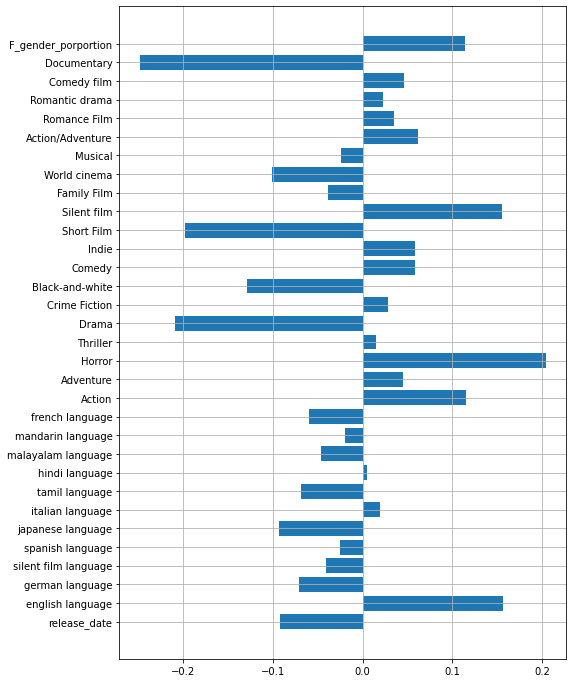

In [60]:
# Plot coefficients
plt.figure(figsize= (8,12))
plt.barh(range(len(coefs)), coefs)
plt.yticks(range(len(coefs)), labels = x_.columns)
plt.grid()
plt.show()

In [72]:
# Analyze model prediction distribution, check class imbalance effect. Select the threshold that maximizes f1 score

pred_space = pd.DataFrame({"score_discretized": y, "pred": lr.predict_proba(X)[:,0]})
best_cutoff = 0
best_f1 = 0

for th in np.linspace(0, 1, 25):
    f1 = f1_score(y, one_vs_all_encode(pred_space.pred, th), pos_label= '5_star')
    
    if f1 > best_f1:
        best_f1 = f1
        best_cutoff = th


best_accuracy = (one_vs_all_encode(pred_space.pred, best_cutoff) == y).sum() / len(y)
        
print(f"Best f1: {best_f1}, best cutoff: {best_cutoff}, best accuracy: {best_accuracy}")

Best f1: 0.405666365975076, best cutoff: 0.20833333333333331, best accuracy: 0.6426835392186402


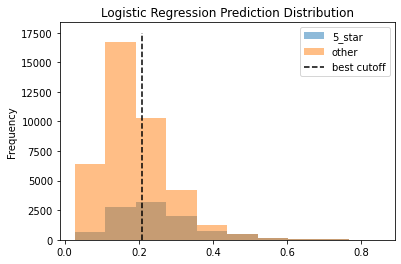

In [73]:
# Plot model prediction distribution
pred_space.pivot(columns = "score_discretized", values = 'pred').plot.hist(alpha = 0.5)
plt.title("Logistic Regression Prediction Distribution")
plt.vlines(best_cutoff, 0, 17500, 'k', linestyles = 'dashed', label = 'best cutoff')
plt.legend()
plt.show()

In [63]:
rf = RandomForestClassifier(10)

rf.fit(X, y)

importances = rf.feature_importances_

print(f"Random Forest accuracy: {rf.score(X, y)}")

Random Forest accuracy: 0.94926182585116


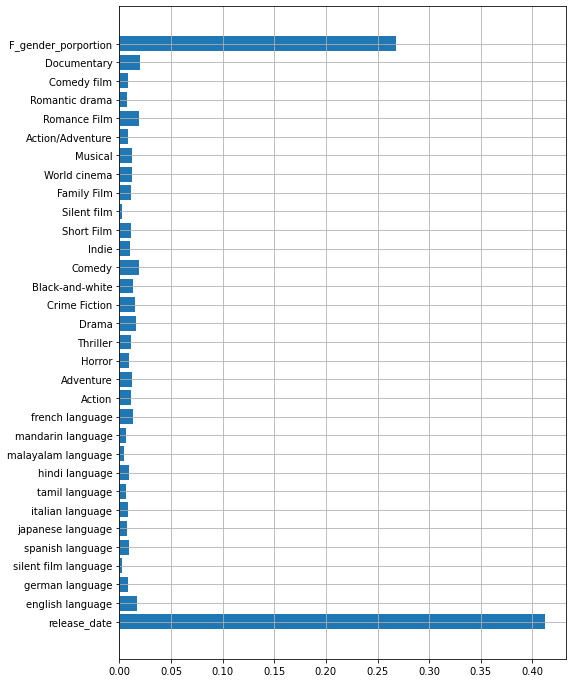

In [64]:
# Plot importances
plt.figure(figsize= (8,12))
plt.barh(range(len(importances)), importances)
plt.yticks(range(len(importances)), labels = x_.columns)
plt.grid()
plt.show()

In [65]:
# Analyze model prediction distribution, check class imbalance effect. Select the threshold that maximizes f1 score

pred_space = pd.DataFrame({"score_discretized": y, "pred": rf.predict_proba(X)[:,0]})
best_cutoff = 0
best_f1 = 0

for th in np.linspace(0, 1, 25):
    f1 = f1_score(y, one_vs_all_encode(pred_space.pred, th), pos_label= '5_star')
    
    if f1 > best_f1:
        best_f1 = f1
        best_cutoff = th


best_accuracy = (one_vs_all_encode(pred_space.pred, best_cutoff) == y).sum() / len(y)
        
print(f"Best f1: {best_f1}, best cutoff: {best_cutoff}, best accuracy: {best_accuracy}")

Best f1: 0.8732615853358887, best cutoff: 0.41666666666666663, best accuracy: 0.9481972481671186


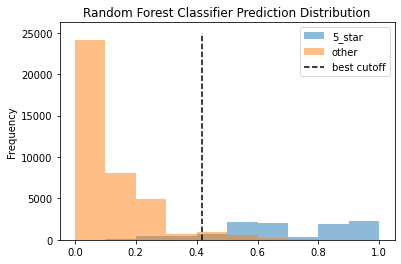

In [70]:
# Plot model prediction distribution
pred_space.pivot(columns = "score_discretized", values = 'pred').plot.hist(alpha = 0.5)
plt.title("Random Forest Classifier Prediction Distribution")
plt.vlines(best_cutoff, 0, 25000, 'k', linestyles = 'dashed', label = 'best cutoff')
plt.legend()
plt.show()

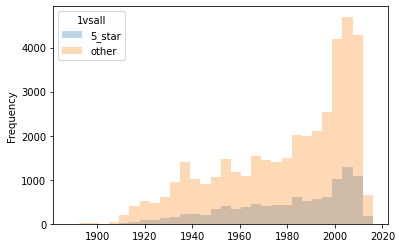

In [67]:
# Release date appears to be important in RF Lets plot its distribution

data.pivot(values = 'release_date', columns = "1vsall").plot.hist(alpha = 0.3, bins = 30)
plt.show()

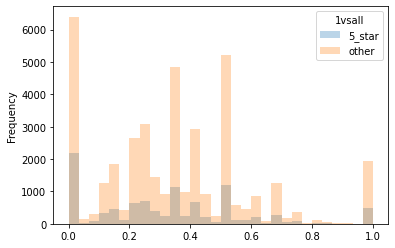

In [68]:
# apparently also gender?

data.pivot(values = 'F_gender_porportion', columns = "1vsall").plot.hist(alpha = 0.3, bins = 30)
plt.show()

At first glance I cannot find any difference in the distributions. So the Random Forest has to be able to figure out the combinations to make it better.

In [43]:


# Iterate on all comparison combinations
for (label_1,df_1), (label_2, df_2) in combinations(data.groupby('1vsall'), 2):
    
    # Drop the separating feature
    vars = df_1.columns.drop(['1vsall','score_discretized'])
    
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
        
    print(f"{label_1} vs {label_2}")
    # Test over all variables with 0.05 significance
    pvalues = test_over_variables(len(vars), vars, 0.05, df_1, df_2)

>>>>>>>>>>>>>>>>>>>>>>>>>>
5_star vs other
_____________________________
34 t-tests with significance: 0.00151
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 6.072210226455398e-12
english language -> pvalue: 7.547776873655137e-93
german language -> pvalue: 9.346017822113613e-22
silent film language -> pvalue: 8.566841257249208e-07
spanish language -> pvalue: 2.616712108290252e-05
japanese language -> pvalue: 4.4829387609378635e-25
tamil language -> pvalue: 4.423372467174952e-19
hindi language -> pvalue: 0.00013192395187010066
malayalam language -> pvalue: 2.8225504042444777e-10
french language -> pvalue: 1.4095185557080784e-25
Action -> pvalue: 2.512729360323937e-46
Adventure -> pvalue: 2.858784610893975e-20
Horror -> pvalue: 1.580439079088995e-74
Thriller -> pvalue: 1.224086521232326e-19
Drama -> pvalue: 3.638316134924318e-70
Crime Fiction -> pvalue: 1.341965433610762e-05
Comedy -> pvalue: 2.8036875515277635e-23
Indie -